

<div style="display:block;width:100%;margin:auto;" direction=rtl align=center><br><br>
    <div  style="width:100%;margin:100;display:block;background-color:#fff0;"  display=block align=center>
        <table style="border-style:hidden;border-collapse:collapse;">             <tr>
                <td  style="border: none!important;">
                    <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
                </td>
                <td style="text-align:center;border: none!important;">
                    <h1 align=center><font size=5 color="#025F5F"> <b>Deep Generative Models</b><br><br>Project 2 GANs and Normalizing Flows </i></font></h1>
                </td>
                <td style="border: none!important;">
                    <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
                </td>
           </tr>
</div>
        </table>
    </div>

## Mohammad Taha Majlesi - 8100101504

Deep Generative Models course - Dr. Tavassoli pour - University of Tehran


# **In the Name of God**  
## **University of Tehran**  
### **School of Engineering, Pardis Campus**  
#### **Department of Electrical and Computer Engineering**  

---

### **Course Title: Deep Generative Models**  
**Instructor:** Dr. Mostafa Tavassoli  
**Homework 2**  
**Submission Date:** November 2023  

---

## **Table of Contents**  

1. **Introduction**  
2. **First Question: Models Based on Normalizing Flows**  
   - Subsection 1: Introduction to RealNVP (4 points)  
   - Subsection 2: Implementation of RealNVP on FashionMNIST (10 points)  
   - Subsection 3: Out-of-Distribution Detection Using Flow-Based Models (3 points)  
   - Subsection 4: Likelihood Evaluation and Analysis (12 points)  
   - Subsection 5: Hidden Space Experiments (6 points)  

3. **Second Question: Generative Adversarial Networks (GANs)**  
   - Subsection 1: Analysis of GAN Training Objectives (5 points)  
   - Subsection 2: Optimal Discriminator Derivation (5 points)  
   - Subsection 3: Discriminator Logit Relationship (3 points)  
   - Subsection 4: WGAN and Its Benefits (5 points)  
   - Subsection 5: Evaluation Metrics for GAN Convergence (4 points)  

4. **Implementation of GAN on FashionMNIST**  
   - Subsection 1: Model Implementation (4 points)  
   - Subsection 2: Role of ConvTranspose2D Layer (6 points)  
   - Subsection 3: Visualization and Analysis of Generated Images (4 points)  
   - Subsection 4: Loss Analysis During Training (4 points)  
   - Subsection 5: FID Score Calculation and Analysis (3 points)  

---

## **1. First Question: Models Based on Normalizing Flows**  

### **1.1 Introduction to RealNVP (4 points)**  

The aim of this section is to provide an introduction to the RealNVP model, which is a type of normalizing flow designed to learn complex distributions. Start by reviewing the provided paper link and summarize its key contributions. Focus particularly on:  

- Log-likelihood calculation.  
- Role of permutation and coupling layers.  

### **1.2 Implementation on FashionMNIST (10 points)**  

In this section, implement the RealNVP model for the FashionMNIST dataset. The implementation involves:  
1. Splitting inputs into two equal parts for coupling transformations.  
2. Using permutation operations for reordering outputs after each transformation.  
3. Training and evaluating the model on subsets of the dataset.  
4. Visualizing a random generated image from the model at different training stages.  

**Expected Deliverables:**  
- Training and testing error plots over epochs.  
- Visualization of generated FashionMNIST images.  

### **1.3 Out-of-Distribution Detection Using Flow-Based Models (3 points)**  

Research and describe an OOD detection method based on probabilistic approaches. Analyze its limitations in detecting OOD samples. Provide insights into the challenges faced by flow-based models in such tasks.  


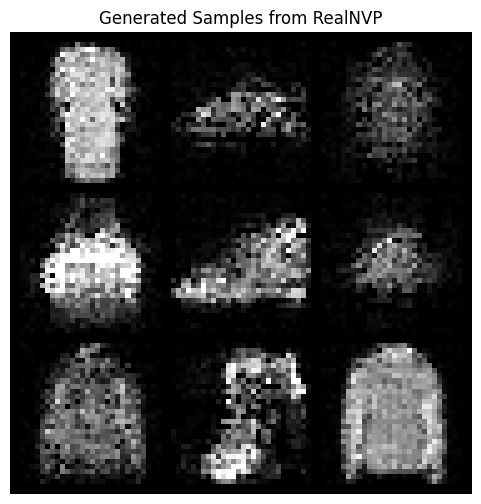

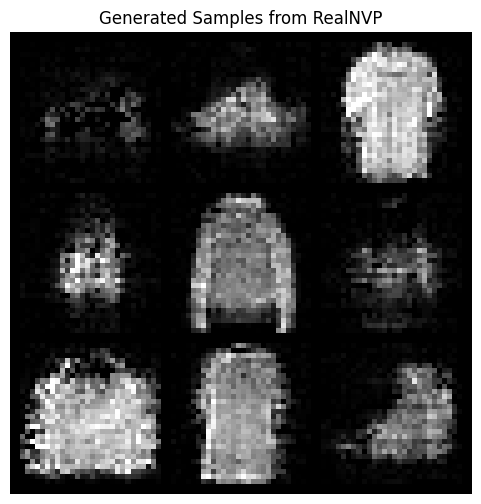

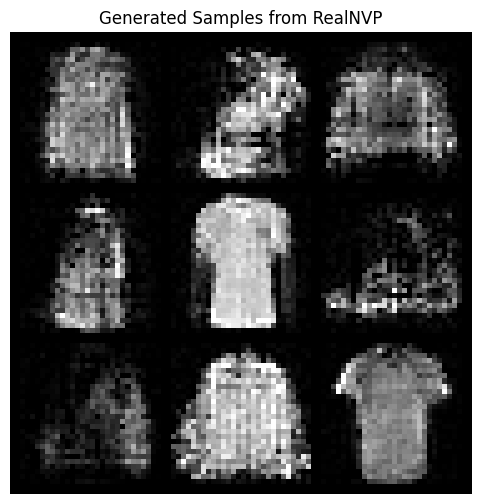

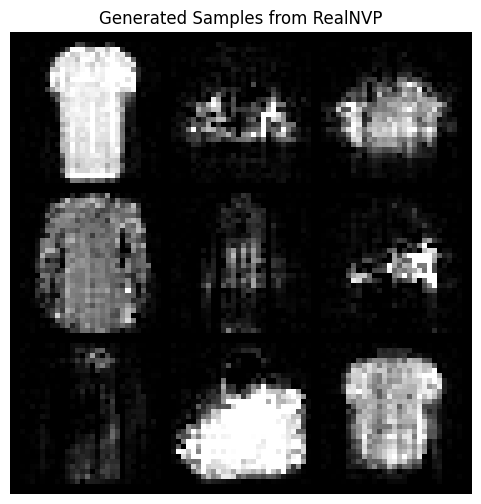

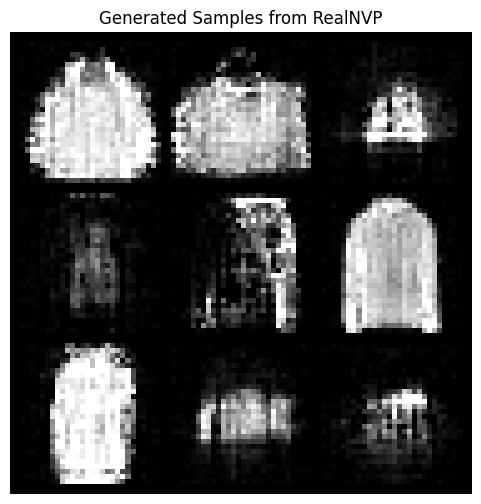

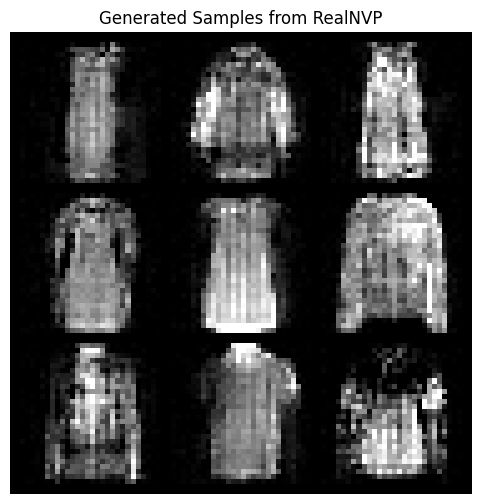

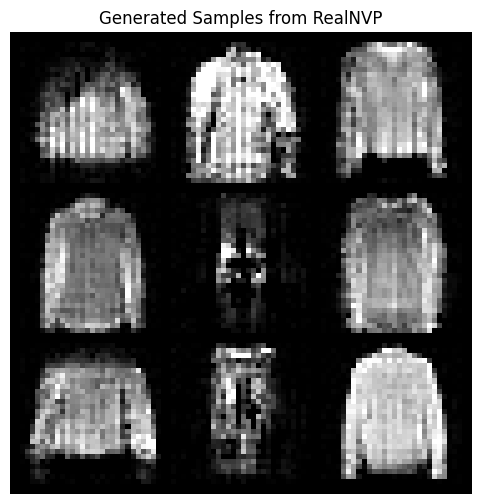

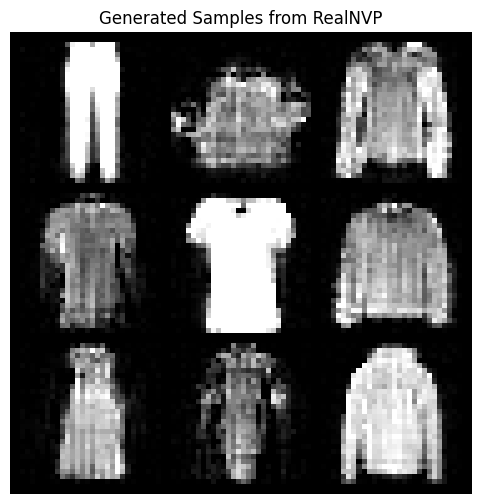

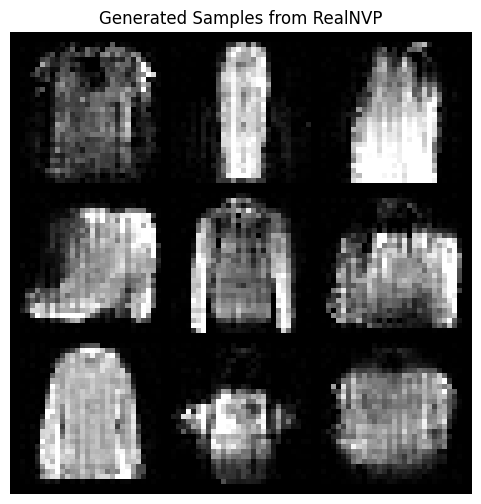

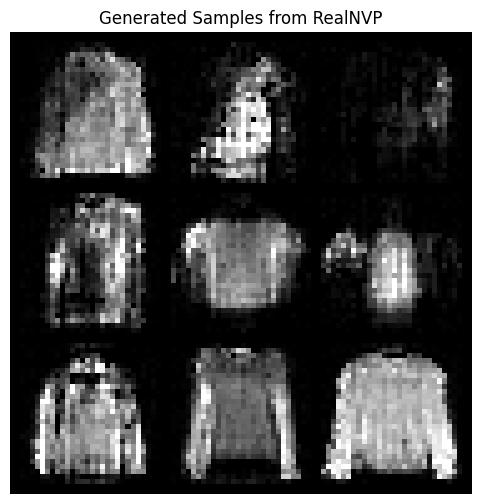

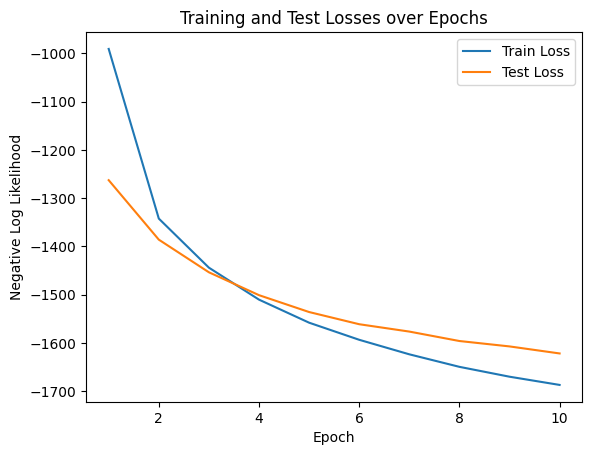

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

batch_size = 128


train_size = int(0.8 * len(train_dataset))
validation_size = len(train_dataset) - train_size

train_subset, validation_subset = random_split(train_dataset, [train_size, validation_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(validation_subset, batch_size=batch_size, shuffle=False)



class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, mask):
        super(CouplingLayer, self).__init__()
        self.register_buffer('mask', mask)
        self.scale_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Tanh()
        )
        self.translate_net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        x_masked = x * self.mask
        s = self.scale_net(x_masked) * (1 - self.mask)
        t = self.translate_net(x_masked) * (1 - self.mask)
        y = x_masked + (1 - self.mask) * (x * torch.exp(s) + t)
        log_det_jacobian = (s * (1 - self.mask)).sum(dim=1)
        return y, log_det_jacobian

    def inverse(self, y):
        y_masked = y * self.mask
        s = self.scale_net(y_masked) * (1 - self.mask)
        t = self.translate_net(y_masked) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * (y - t) * torch.exp(-s)
        return x

class RealNVP(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_coupling_layers):
        super(RealNVP, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_coupling_layers = num_coupling_layers

        masks = []
        for i in range(num_coupling_layers):
            mask = np.zeros(input_dim)
            if i % 2 == 0:
                mask[::2] = 1
            else:
                mask[1::2] = 1
            mask = torch.from_numpy(mask.astype(np.float32))
            masks.append(mask)

        self.layers = nn.ModuleList()
        for i in range(num_coupling_layers):
            self.layers.append(CouplingLayer(input_dim, hidden_dim, masks[i]))

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

input_dim = 28 * 28
hidden_dim = 1024
num_coupling_layers = 8
num_epochs = 10
learning_rate = 1e-3

model = RealNVP(input_dim, hidden_dim, num_coupling_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, input_dim).to(device)
        optimizer.zero_grad()
        z, log_det_jacobian = model(data)

        log_pz = -0.5 * torch.sum(z ** 2 + np.log(2 * np.pi), dim=1)
        loss = -torch.mean(log_pz + log_det_jacobian)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, input_dim).to(device)
            z, log_det_jacobian = model(data)
            log_pz = -0.5 * torch.sum(z ** 2 + np.log(2 * np.pi), dim=1)
            loss = -torch.mean(log_pz + log_det_jacobian)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)

    with torch.no_grad():
        z = torch.randn(9, input_dim).to(device)
        x_samples = model.inverse(z)
        x_samples = x_samples.cpu().view(-1, 1, 28, 28)

        grid_img = torchvision.utils.make_grid(x_samples, nrow=3, padding=2)
        plt.figure(figsize=(6,6))
        plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Generated Samples from RealNVP')
        plt.show()



plt.figure()
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Negative Log Likelihood')
plt.legend()
plt.title('Training and Test Losses over Epochs')
plt.show()




This code implements **RealNVP (Real-valued Non-Volume Preserving Transformation)**, a type of normalizing flow model, to learn a transformation from a simple latent space (e.g., Gaussian) to a more complex data distribution (FashionMNIST). Here’s a detailed conceptual explanation:

---

### **1. Overview of Normalizing Flows**
Normalizing flows are a type of generative model that learns complex data distributions by transforming a simple distribution (like Gaussian) into the data distribution using invertible transformations.

Key components include:
- **Invertible Transformations:** Each transformation can be reversed, allowing sampling from the learned distribution.
- **Log-Determinant Jacobian:** Tracks how the transformation affects probability density, essential for computing the likelihood.

---

### **2. Dataset Preparation**
- **FashionMNIST Dataset:** This is a dataset of grayscale images of clothing items.
- **Train/Test Split:** The dataset is divided into a training subset (80%) and a validation subset (20%).
- **DataLoader:** Batches of images are prepared for training and testing.

---

### **3. RealNVP Model Architecture**

#### **a. Coupling Layers**
The RealNVP architecture is composed of **coupling layers**, which are the building blocks for creating invertible transformations:
1. **Masking Mechanism:** Input features are split into two groups (e.g., alternating elements based on a mask). One group is transformed while the other remains unchanged.
2. **Scale and Translation Networks:**
   - A neural network predicts scaling factors ($s$) and translation terms $(t$) for the transform.
   - The transformation is defined as:
     $$
     y = x_{\text{masked}} + (1 - \text{mask}) \times (x \cdot e^s + t)
     $$
   - \(s\) and \(t\) only affect unmasked inputs, maintaining invertibility.
3. **Inverse Transformation:** Inverting this transformation during sampling is straightforward:
     $$
     x = y_{\text{masked}} + (1 - \text{mask}) \times (y - t) \cdot e^{-s}
     $$

#### **b. Stacking Coupling Layers**
- Multiple coupling layers are stacked to progressively increase the expressiveness of the transformation.
- Masks alternate between layers to ensure all features are transformed over multiple layers.

---

### **4. Training Objective**
The RealNVP model is trained by maximizing the **log-likelihood** of the data. This involves:
1. **Forward Transformation:** Each data sample is transformed into the latent space (\(z\)) using the coupling layers.
2. **Likelihood Computation:**
   - \(z\) follows a simple Gaussian distribution (\(\mathcal{N}(0, I)\)).
   - The log-likelihood is:
     $$
     \log p(x) = \log p(z) + \text{log-determinant of the Jacobian}.
     $$
     - **Log-Determinant Jacobian:** Accounts for how the transformation changes the density.
     - **Log-Likelihood of \(z\):** Computed under the Gaussian distribution:
       $$
       \log p(z) = -0.5 \sum z^2 + \text{constant}.
       $$
3. **Loss Function:** The **negative log-likelihood** is minimized during training:
   $$
   \text{Loss} = - \mathbb{E}[\log p(x)].
   $$

---

### **5. Sampling from the Model**
After training, the model can generate new samples:
1. **Latent Space Sampling:** Random points are drawn from the Gaussian latent space.
2. **Inverse Transformation:** These points are mapped back to the data space using the inverse transformation, producing synthetic samples resembling the training data.

---

### **6. Training and Validation**
- **Training Phase:** The model is trained on batches of images to minimize the negative log-likelihood.
- **Validation Phase:** The model's performance is evaluated on the validation dataset using the same loss function.

---

### **7. Visualizing Generated Samples**
During training, the model periodically generates new samples:
- Random points are sampled from the latent space.
- These points are transformed back to the image space using the inverse function.
- The generated images are displayed, showing how well the model learns the data distribution.

---

### **8. Loss Visualization**
At the end of training:
- The **training loss** (on the training dataset) and **test loss** (on the validation dataset) are plotted.
- The trend of the loss values over epochs indicates:
  - **Convergence:** A decrease in loss suggests the model is learning effectively.
  - **Overfitting:** A divergence between training and validation loss might indicate overfitting.

---

### **Key Concepts Covered**
1. **Coupling Layers:** Key components of RealNVP that enable invertible and efficient transformations.
2. **Log-Determinant Jacobian:** Tracks density changes during transformation.
3. **Latent Space Mapping:** Links the Gaussian latent space to the complex data distribution.
4. **Likelihood Maximization:** Core training objective that ensures the model learns the data distribution.
5. **Sampling:** Demonstrates how new samples resembling the original data are generated.

---

### **Conclusion**
This code effectively implements RealNVP to model the FashionMNIST distribution. The training process involves learning a transformation from a Gaussian latent space to the data distribution, and the results are evaluated both quantitatively (loss values) and qualitatively (visualized samples). The approach highlights the power of normalizing flows in generative modeling.

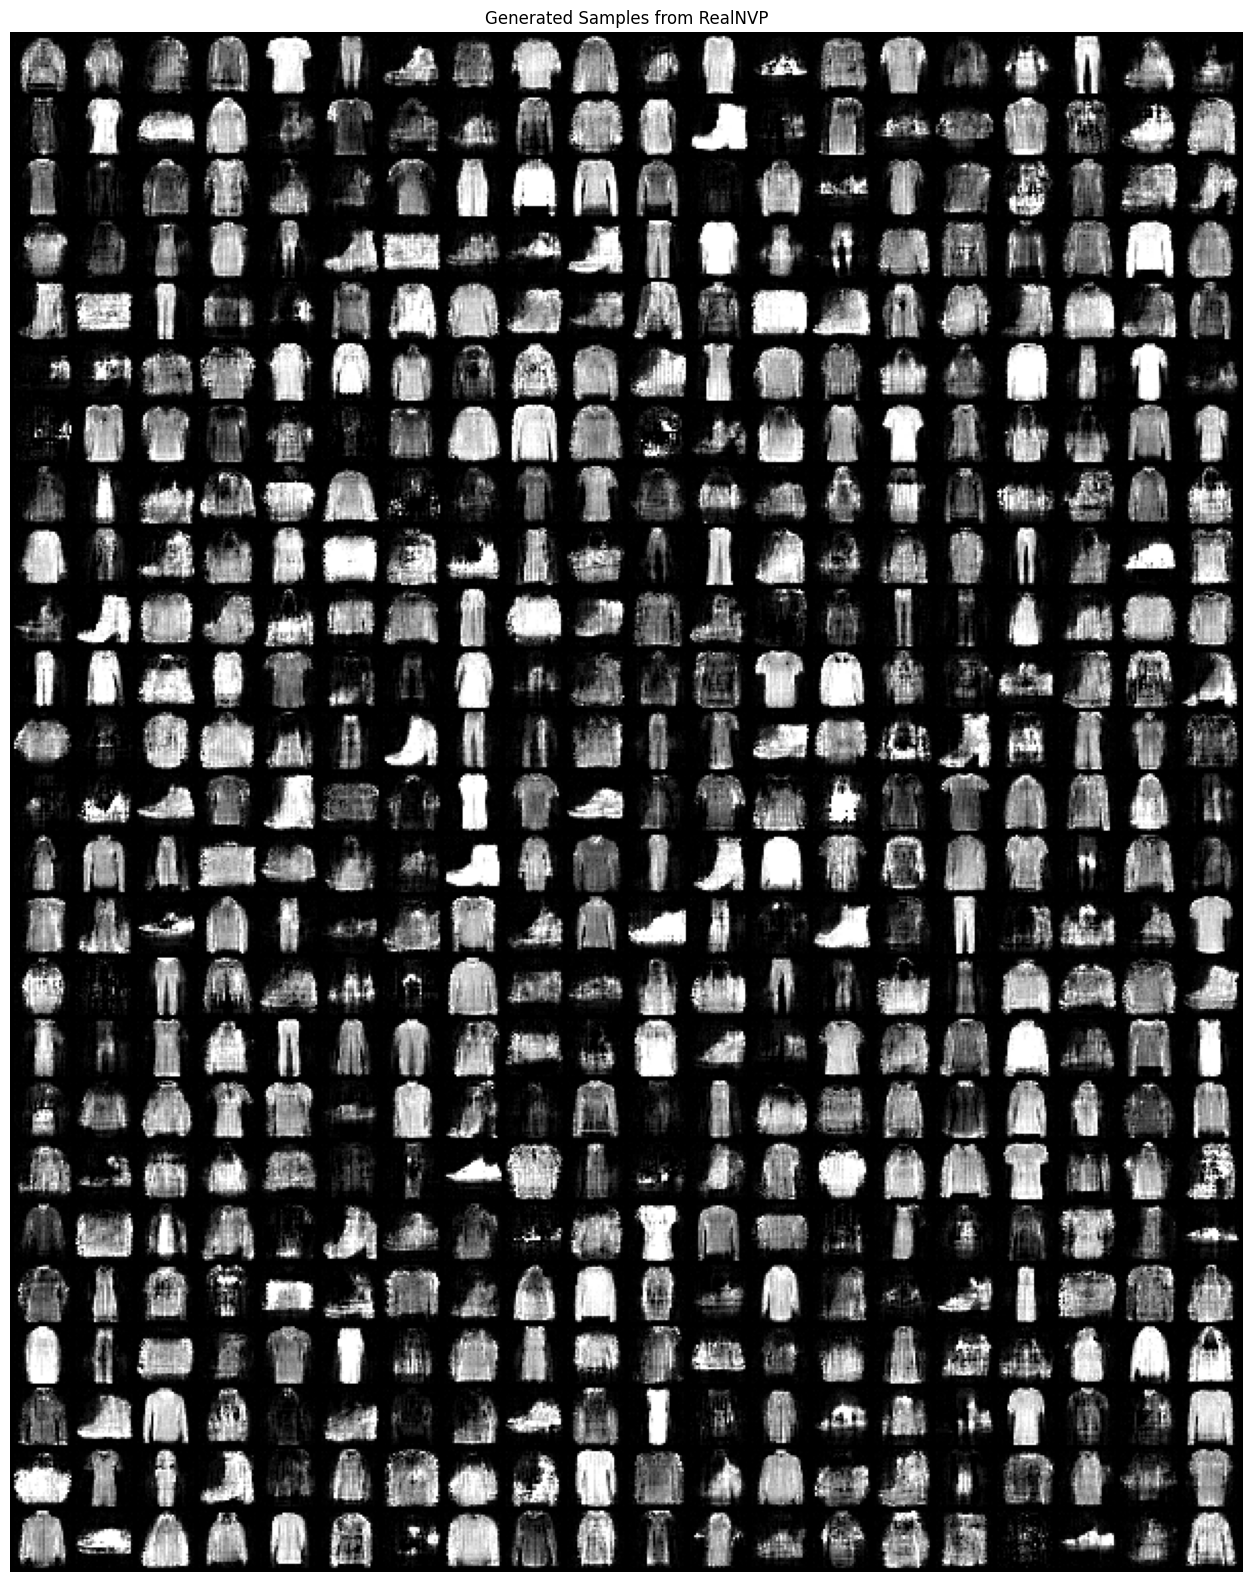

In [22]:
    with torch.no_grad():
        z = torch.randn(500, input_dim).to(device)
        x_samples = model.inverse(z)
        x_samples = x_samples.cpu().view(-1, 1, 28, 28)

        grid_img = torchvision.utils.make_grid(x_samples, nrow=20, padding=2)
        plt.figure(figsize=(20,20))
        plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
        plt.axis('off')
        plt.title('Generated Samples from RealNVP')
        plt.show()



In [7]:
from torchvision.datasets import MNIST, KMNIST

mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)
kmnist_test = KMNIST(root='./data', train=False, download=True, transform=transform)

mnist_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
kmnist_loader = DataLoader(kmnist_test, batch_size=batch_size, shuffle=False)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.23MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.06MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 18.2M/18.2M [00:08<00:00, 2.20MB/s]


Extracting ./data/KMNIST/raw/train-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 459kB/s]


Extracting ./data/KMNIST/raw/train-labels-idx1-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 3.04M/3.04M [00:01<00:00, 1.58MB/s]


Extracting ./data/KMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/KMNIST/raw



100%|██████████| 5.12k/5.12k [00:00<00:00, 22.6MB/s]

Extracting ./data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/KMNIST/raw



In [12]:
def compute_log_likelihood(model, data_loader):
    model.eval()
    log_likelihoods = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.view(-1, input_dim).to(device)
            z, log_det_jacobian = model(data)
            log_pz = -0.5 * torch.sum(z ** 2 + np.log(2 * np.pi), dim=1)
            log_px = log_pz + log_det_jacobian
            log_likelihoods.append(log_px.cpu().numpy())
    return np.concatenate(log_likelihoods)




In [14]:
fashion_train_ll = compute_log_likelihood(model, train_loader)
fashion_test_ll = compute_log_likelihood(model, test_loader)
mnist_ll = compute_log_likelihood(model, mnist_loader)
kmnist_ll = compute_log_likelihood(model, kmnist_loader)

print("Fashion MNIST Train Log Likelihood:", np.mean(fashion_train_ll))
print("Fashion MNIST Test Log Likelihood:", np.mean(fashion_test_ll))
print("MNIST Log Likelihood:", np.mean(mnist_ll))
print("KMNIST Log Likelihood:", np.mean(kmnist_ll))

Fashion MNIST Train Log Likelihood: 1706.9332
Fashion MNIST Test Log Likelihood: 1621.3966
MNIST Log Likelihood: 890.0156
KMNIST Log Likelihood: -1850.9489


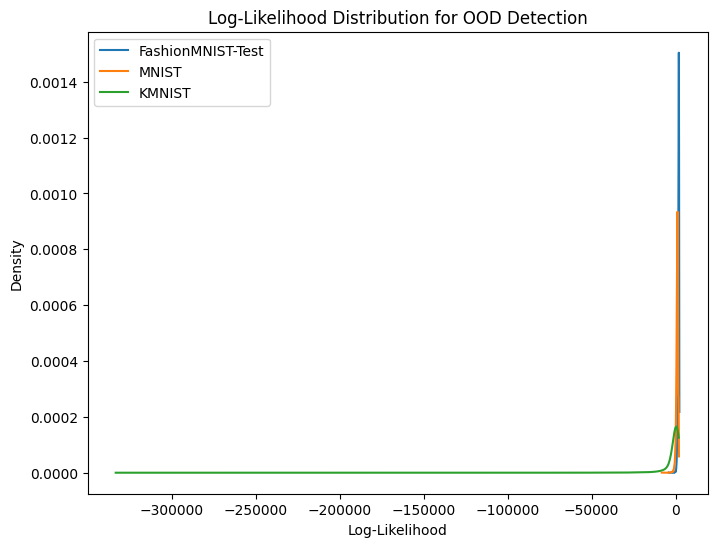

In [ ]:
from scipy.stats import gaussian_kde


def plot_kde(log_likelihoods, labels, title):
    plt.figure(figsize=(8, 6))
    for ll, label in zip(log_likelihoods, labels):
        kde = gaussian_kde(ll)
        x_vals = np.linspace(min(ll), max(ll), 1000)
        plt.plot(x_vals, kde(x_vals), label=label)
    plt.title(title)
    plt.xlabel('Log-Likelihood')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_kde(
    [fashion_test_ll, mnist_ll, kmnist_ll],
    ['FashionMNIST-Test', 'MNIST', 'KMNIST'],
    'Log-Likelihood Distribution for OOD Detection'
)


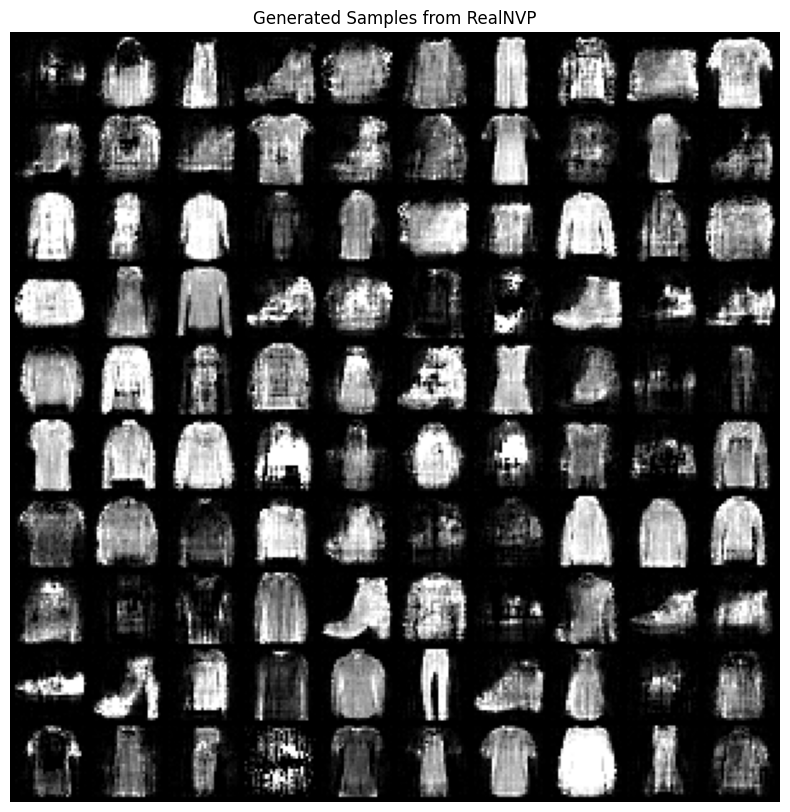

In [23]:
with torch.no_grad():
    z = torch.randn(100, input_dim).to(device)
    x_samples = model.inverse(z)
    x_samples = x_samples.cpu().view(-1, 1, 28, 28)

    grid_img = torchvision.utils.make_grid(x_samples, nrow=10, padding=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.axis('off')
    plt.title('Generated Samples from RealNVP')
    plt.show()


In [19]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )

    def forward(self, x):
        return self.decoder(x)


In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, latent_dim)
        )

    def forward(self, x):
        return self.encoder(x)


In [27]:
encoder = Encoder(input_dim, latent_dim).to(device)
decoder = Decoder(latent_dim, input_dim).to(device)

encoder_decoder_optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=learning_rate)

for epoch in range(num_epochs_encoder):
    encoder.train()
    decoder.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.view(-1, input_dim).to(device)
        encoder_decoder_optimizer.zero_grad()
        latent = encoder(data)
        reconstructed = decoder(latent)
        loss = nn.MSELoss()(reconstructed, data)
        loss.backward()
        encoder_decoder_optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, Encoder-Decoder Train Loss: {train_loss / len(train_loader)}")


Epoch 1, Encoder-Decoder Train Loss: 0.023270415611565114
Epoch 2, Encoder-Decoder Train Loss: 0.011565871966381867
Epoch 3, Encoder-Decoder Train Loss: 0.009415138490498066
Epoch 4, Encoder-Decoder Train Loss: 0.008324965931475163
Epoch 5, Encoder-Decoder Train Loss: 0.007560793660581112


In [28]:
def encode_dataset(encoder, data_loader):
    encoded_data = []
    with torch.no_grad():
        for data, _ in data_loader:
            data = data.view(-1, input_dim).to(device)
            latent = encoder(data)
            encoded_data.append(latent.cpu())
    return torch.cat(encoded_data)

fashion_train_latent = encode_dataset(encoder, train_loader)
fashion_test_latent = encode_dataset(encoder, test_loader)
mnist_latent = encode_dataset(encoder, mnist_loader)
kmnist_latent = encode_dataset(encoder, kmnist_loader)


In [29]:
latent_input_dim = latent_dim
realnvp_model = RealNVP(latent_input_dim, hidden_dim, num_coupling_layers).to(device)
realnvp_optimizer = optim.Adam(realnvp_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    realnvp_model.train()
    train_loss = 0
    for i in range(0, len(fashion_train_latent), batch_size):
        batch = fashion_train_latent[i:i + batch_size].to(device)
        realnvp_optimizer.zero_grad()
        z, log_det_jacobian = realnvp_model(batch)
        log_pz = -0.5 * torch.sum(z ** 2 + np.log(2 * np.pi), dim=1)
        loss = -torch.mean(log_pz + log_det_jacobian)
        loss.backward()
        realnvp_optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}, RealNVP Train Loss: {train_loss / len(train_loader)}")


Epoch 1, RealNVP Train Loss: -87.72435881169638
Epoch 2, RealNVP Train Loss: -127.87423897298177
Epoch 3, RealNVP Train Loss: -140.1823764851888
Epoch 4, RealNVP Train Loss: -147.2096374511719
Epoch 5, RealNVP Train Loss: -151.80243831380207
Epoch 6, RealNVP Train Loss: -155.68333422851563
Epoch 7, RealNVP Train Loss: -158.78502693684896
Epoch 8, RealNVP Train Loss: -160.62903662109375
Epoch 9, RealNVP Train Loss: -162.99135953776042
Epoch 10, RealNVP Train Loss: -164.52040258789063


In [30]:
def compute_log_likelihood_latent(model, data):
    model.eval()
    log_likelihoods = []
    with torch.no_grad():
        for i in range(0, len(data), batch_size):
            batch = data[i:i + batch_size].to(device)
            z, log_det_jacobian = model(batch)
            log_pz = -0.5 * torch.sum(z ** 2 + np.log(2 * np.pi), dim=1)
            log_px = log_pz + log_det_jacobian
            log_likelihoods.append(log_px.cpu().numpy())
    return np.concatenate(log_likelihoods)

fashion_train_ll = compute_log_likelihood_latent(realnvp_model, fashion_train_latent)
fashion_test_ll = compute_log_likelihood_latent(realnvp_model, fashion_test_latent)
mnist_ll = compute_log_likelihood_latent(realnvp_model, mnist_latent)
kmnist_ll = compute_log_likelihood_latent(realnvp_model, kmnist_latent)

print("FashionMNIST Train Log-Likelihood:", np.mean(fashion_train_ll))
print("FashionMNIST Test Log-Likelihood:", np.mean(fashion_test_ll))
print("MNIST Log-Likelihood:", np.mean(mnist_ll))
print("KMNIST Log-Likelihood:", np.mean(kmnist_ll))


FashionMNIST Train Log-Likelihood: 166.30286
FashionMNIST Test Log-Likelihood: 151.63997
MNIST Log-Likelihood: 2.3912132
KMNIST Log-Likelihood: -66.17415


---

## **2. Second Question: Generative Adversarial Networks (GANs)**  

### **2.1 Analysis of GAN Training Objectives (5 points)**  

Generative Adversarial Networks (GANs) are trained by optimizing two competing objectives:  

1. **Discriminator Loss**:  
   The discriminator attempts to distinguish real images from generated ones. Its loss function is:  
   $$
   L_D(\phi; \theta) = - \mathbb{E}_{x \sim p_{\text{data}}(x)}[\log D_\phi(x)] - \mathbb{E}_{z \sim N(0, 1)}[\log(1 - D_\phi(G_\theta(z)))]
   $$

2. **Generator Loss**:  
   The generator attempts to generate realistic samples to fool the discriminator. Its loss function is:  
   $$
   L_G(\phi; \theta) = \mathbb{E}_{z \sim N(0, 1)}[\log(1 - D_\phi(G_\theta(z)))]
   $$

Discuss the issue of vanishing gradients in these loss functions and how it impacts the generator's training.

---

### **2.2 Optimal Discriminator Derivation (5 points)**  

The optimal discriminator is achieved when:  
$$
D^*(x) = \frac{p_{\text{data}}(x)}{p_{\text{data}}(x) + p_\theta(x)}
$$
Using this formulation, derive the optimal discriminator loss and explain how it relates to the Jensen-Shannon divergence between the real and generated data distributions.

---

### **2.3 Discriminator Logit Relationship (3 points)**  

For the discriminator $ D_\phi(x) $, where $ D_\phi(x) = \sigma(h_\phi(x)) $:  

1. Show that $ h_\phi(x) = \log \frac{p_{\text{data}}(x)}{p_\theta(x)} \
$ when $ D_\phi = D^* $.  
2. Explain how this logit relates to the log-density ratio between the real and generated data distributions.

---

### **2.4 WGAN and Its Benefits (5 points)**  

Wasserstein GAN (WGAN) addresses key issues in traditional GANs, including:  
- **Vanishing Gradients**: Replaces the JS divergence with the Wasserstein distance.  
- **Improved Convergence**: Allows the generator to provide meaningful gradients even when the discriminator is near optimal.  

The Wasserstein distance is defined as:  
$$
W(p_r, p_\theta) = \sup_{\|f\|_L \leq 1} \left[ \mathbb{E}_{x \sim p_r}[f(x)] - \mathbb{E}_{x \sim p_\theta}[f(x)] \right]
$$

Discuss how the use of weight clipping and the Lipschitz constraint helps improve stability in GAN training.

---

### **2.5 Evaluation Metrics for GAN Convergence (4 points)**  

Discuss metrics for evaluating GAN performance, including:  

1. **Frechet Inception Distance (FID)**:  
   Measures the distance between feature distributions of real and generated images.  

2. **Wasserstein Distance**:  
   Directly measures the overlap between real and generated distributions.  

3. **Visual Quality**:  
   Qualitative evaluation of generated samples.  

Explain how these metrics help ensure convergence towards realistic image generation.

---

## **3. Implementation of GAN on FashionMNIST**  

### **3.1 Model Implementation (4 points)**  

Implement the generator and discriminator models as described in the assignment. Ensure the following architecture:  

### **3.2 Role of ConvTranspose2D Layer (6 points)**  

Explain the role of the `ConvTranspose2D` layer in the generator architecture. Specifically:  
- How it increases the spatial dimensions of the input.  
- The relationship between kernel size, stride, and padding in determining the output size.  

Include the formula for calculating the output size of a transpose convolution.

---

### **3.3 Visualization and Analysis of Generated Images (4 points)**  

Train the GAN on FashionMNIST and visualize the generated images at:  
1. Initial epoch.  
2. Midway through training.  
3. Final epoch.  

Compare these with real samples to analyze improvements in image quality over epochs.

---

### **3.4 Loss Analysis During Training (4 points)**  

Plot the loss values for the generator and discriminator over training epochs. Analyze:  
- How the losses evolve.  
- What this indicates about the generator-discriminator dynamic.  

---

### **3.5 FID Score Calculation and Analysis (3 points)**  

Compute the Frechet Inception Distance (FID) for the generated images at:  
- Initial epoch.  
- Midway through training.  
- Final epoch.  

Discuss how the FID values reflect improvements (or lack thereof) in the quality of generated images.  

---


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torchvision.utils as vutils

latent_dim = 100
lr = 0.0002
batch_size = 64
epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


class Generator(nn.Module):
    def __init__(self, latent_dim=100):
        super(Generator, self).__init__()
        ngf = 64
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.model(input)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        ndf = 64
        self.model = nn.Sequential(
            nn.Conv2d(1, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.model(input).view(-1, 1)

class GAN:
    def __init__(self, latent_dim=100, lr=0.0002):
        self.generator = Generator(latent_dim).to(device)
        self.discriminator = Discriminator().to(device)
        self.latent_dim = latent_dim

        self.criterion = nn.BCELoss()

        self.optimizer_G = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(0.5, 0.999))
        self.optimizer_D = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
real_path = './real_images'
generated_path = './generated_images'

if not os.path.exists(real_path):
    os.makedirs(real_path)
    print(f"Created directory: {real_path}")

if not os.path.exists(generated_path):
    os.makedirs(generated_path)
    print(f"Created directory: {generated_path}")

gan = GAN(latent_dim=latent_dim, lr=lr)
fixed_noise = torch.randn(25, latent_dim, 1, 1, device=device)

G_losses = []
D_losses = []


[Epoch 1/10] [Batch 0/938] [D loss: 0.6795] [G loss: 0.6267]
[Epoch 1/10] [Batch 100/938] [D loss: 0.0013] [G loss: 6.2292]
[Epoch 1/10] [Batch 200/938] [D loss: 0.0377] [G loss: 13.4333]
[Epoch 1/10] [Batch 300/938] [D loss: 0.0849] [G loss: 2.5734]
[Epoch 1/10] [Batch 400/938] [D loss: 0.3171] [G loss: 1.1969]
[Epoch 1/10] [Batch 500/938] [D loss: 0.6135] [G loss: 0.4932]
[Epoch 1/10] [Batch 600/938] [D loss: 0.2599] [G loss: 1.8977]
[Epoch 1/10] [Batch 700/938] [D loss: 0.3166] [G loss: 2.0946]
[Epoch 1/10] [Batch 800/938] [D loss: 0.3741] [G loss: 1.2295]
[Epoch 1/10] [Batch 900/938] [D loss: 0.4286] [G loss: 3.1867]


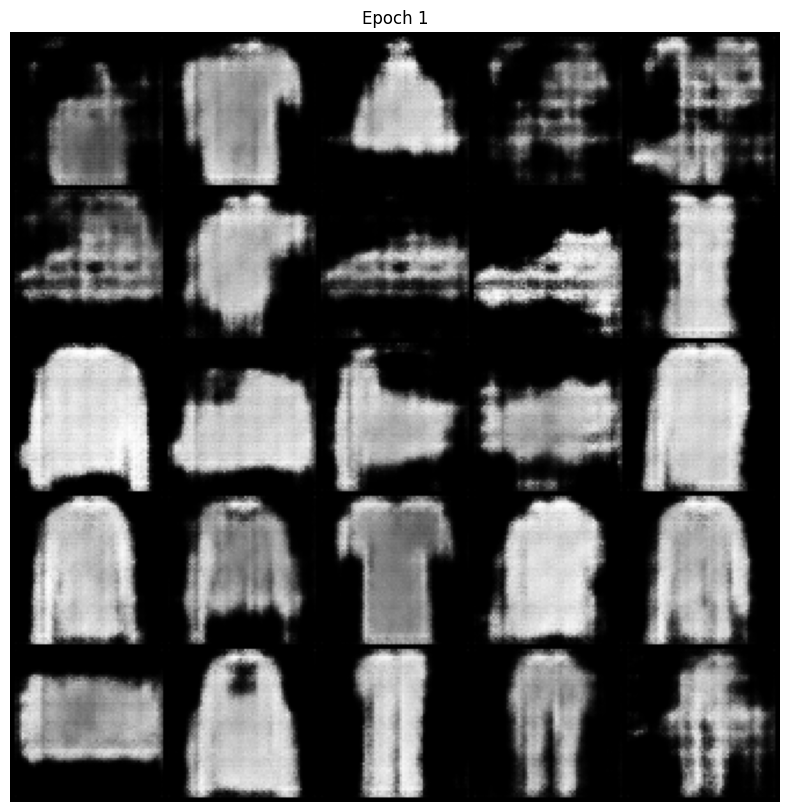

[Epoch 2/10] [Batch 0/938] [D loss: 1.0065] [G loss: 0.1944]
[Epoch 2/10] [Batch 100/938] [D loss: 0.3785] [G loss: 1.0119]
[Epoch 2/10] [Batch 200/938] [D loss: 0.6647] [G loss: 0.4964]
[Epoch 2/10] [Batch 300/938] [D loss: 0.2792] [G loss: 1.3665]
[Epoch 2/10] [Batch 400/938] [D loss: 0.2359] [G loss: 1.7623]
[Epoch 2/10] [Batch 500/938] [D loss: 0.2811] [G loss: 1.1235]
[Epoch 2/10] [Batch 600/938] [D loss: 0.2675] [G loss: 1.5690]
[Epoch 2/10] [Batch 700/938] [D loss: 0.3596] [G loss: 2.9322]
[Epoch 2/10] [Batch 800/938] [D loss: 0.1610] [G loss: 2.1583]
[Epoch 2/10] [Batch 900/938] [D loss: 0.1360] [G loss: 4.0601]


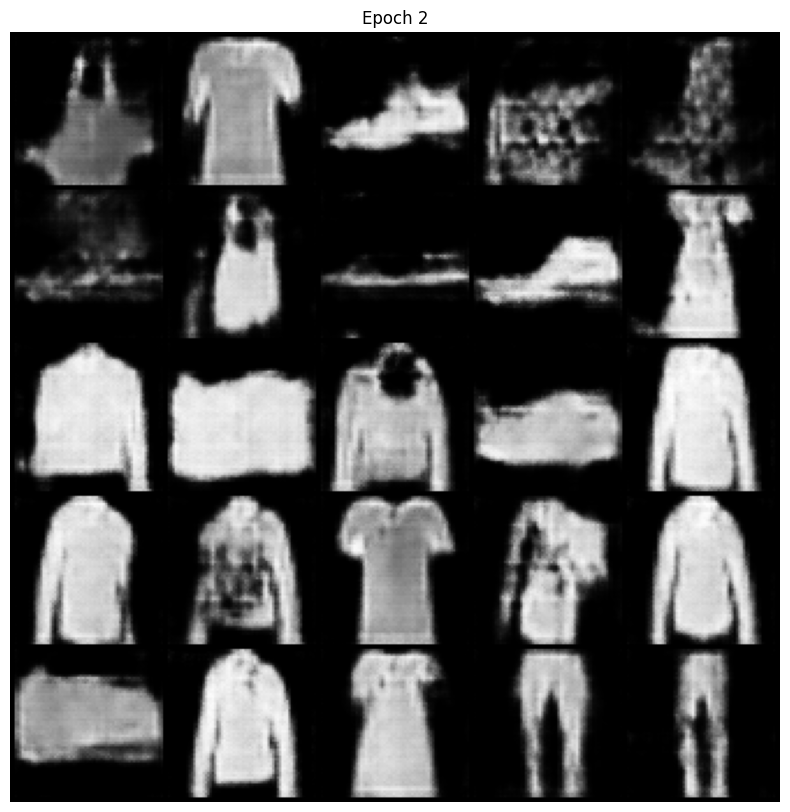

[Epoch 3/10] [Batch 0/938] [D loss: 0.1424] [G loss: 2.0226]
[Epoch 3/10] [Batch 100/938] [D loss: 0.1659] [G loss: 2.0329]
[Epoch 3/10] [Batch 200/938] [D loss: 0.2886] [G loss: 1.1500]
[Epoch 3/10] [Batch 300/938] [D loss: 0.0420] [G loss: 3.2708]
[Epoch 3/10] [Batch 400/938] [D loss: 0.2792] [G loss: 3.2414]
[Epoch 3/10] [Batch 500/938] [D loss: 0.1592] [G loss: 2.9960]
[Epoch 3/10] [Batch 600/938] [D loss: 0.1728] [G loss: 1.7698]
[Epoch 3/10] [Batch 700/938] [D loss: 0.1510] [G loss: 2.0431]
[Epoch 3/10] [Batch 800/938] [D loss: 0.1325] [G loss: 2.5134]
[Epoch 3/10] [Batch 900/938] [D loss: 0.0377] [G loss: 3.8909]


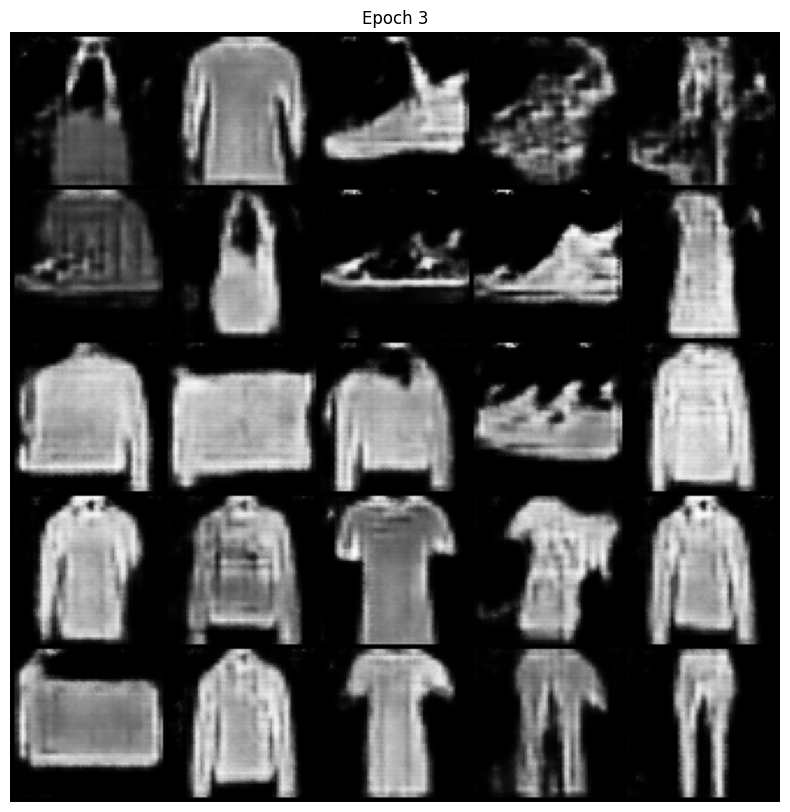

[Epoch 4/10] [Batch 0/938] [D loss: 0.2671] [G loss: 2.4144]
[Epoch 4/10] [Batch 100/938] [D loss: 0.0436] [G loss: 3.3748]
[Epoch 4/10] [Batch 200/938] [D loss: 0.0136] [G loss: 5.5982]
[Epoch 4/10] [Batch 300/938] [D loss: 0.1850] [G loss: 1.6275]
[Epoch 4/10] [Batch 400/938] [D loss: 0.6706] [G loss: 0.7082]
[Epoch 4/10] [Batch 500/938] [D loss: 0.0701] [G loss: 3.6159]
[Epoch 4/10] [Batch 600/938] [D loss: 0.0973] [G loss: 2.7222]
[Epoch 4/10] [Batch 700/938] [D loss: 0.0256] [G loss: 3.4556]
[Epoch 4/10] [Batch 800/938] [D loss: 0.1740] [G loss: 4.0230]
[Epoch 4/10] [Batch 900/938] [D loss: 0.2215] [G loss: 1.6784]


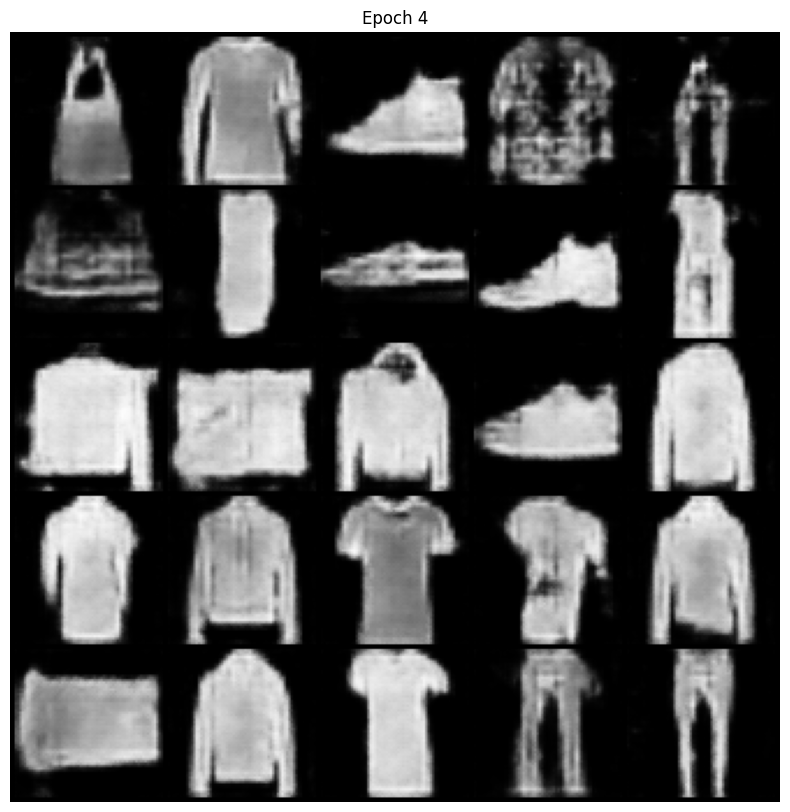

[Epoch 5/10] [Batch 0/938] [D loss: 0.0929] [G loss: 2.7903]
[Epoch 5/10] [Batch 100/938] [D loss: 0.0644] [G loss: 5.1395]
[Epoch 5/10] [Batch 200/938] [D loss: 0.0356] [G loss: 9.1352]
[Epoch 5/10] [Batch 300/938] [D loss: 0.0611] [G loss: 3.5596]
[Epoch 5/10] [Batch 400/938] [D loss: 0.2820] [G loss: 5.9128]
[Epoch 5/10] [Batch 500/938] [D loss: 0.0286] [G loss: 3.4545]
[Epoch 5/10] [Batch 600/938] [D loss: 0.0779] [G loss: 3.1224]
[Epoch 5/10] [Batch 700/938] [D loss: 0.0149] [G loss: 5.2746]
[Epoch 5/10] [Batch 800/938] [D loss: 0.0673] [G loss: 4.9205]
[Epoch 5/10] [Batch 900/938] [D loss: 0.0418] [G loss: 4.1381]


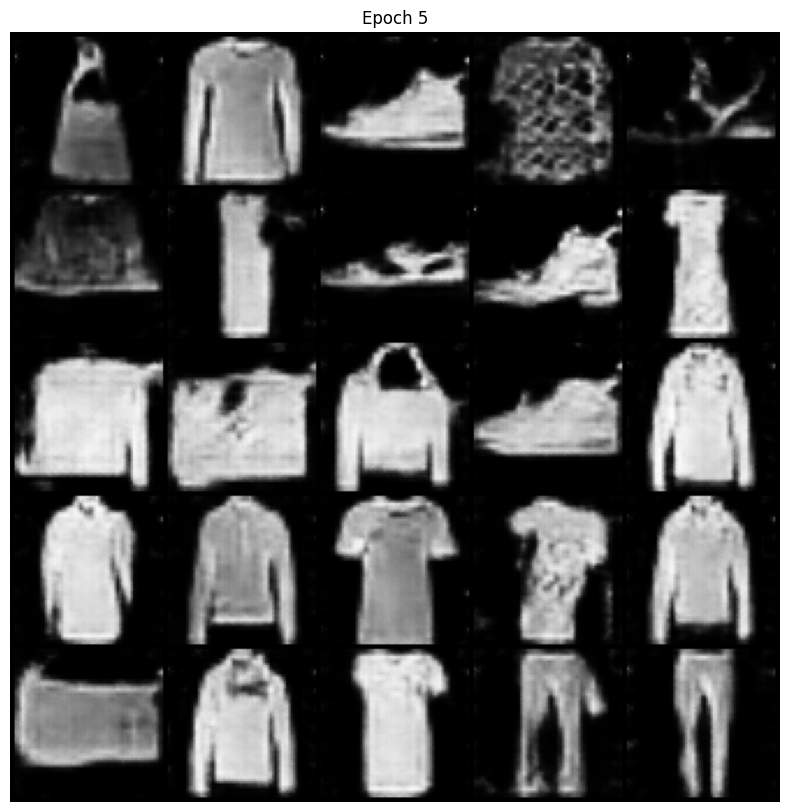

[Epoch 6/10] [Batch 0/938] [D loss: 0.0126] [G loss: 4.7262]
[Epoch 6/10] [Batch 100/938] [D loss: 0.0151] [G loss: 4.7582]
[Epoch 6/10] [Batch 200/938] [D loss: 0.7281] [G loss: 0.6979]
[Epoch 6/10] [Batch 300/938] [D loss: 0.1646] [G loss: 3.5880]
[Epoch 6/10] [Batch 400/938] [D loss: 0.0298] [G loss: 4.4077]
[Epoch 6/10] [Batch 500/938] [D loss: 0.4133] [G loss: 2.4325]
[Epoch 6/10] [Batch 600/938] [D loss: 0.2509] [G loss: 1.6269]
[Epoch 6/10] [Batch 700/938] [D loss: 0.0408] [G loss: 3.3380]
[Epoch 6/10] [Batch 800/938] [D loss: 0.0185] [G loss: 4.1779]
[Epoch 6/10] [Batch 900/938] [D loss: 0.0542] [G loss: 3.4472]


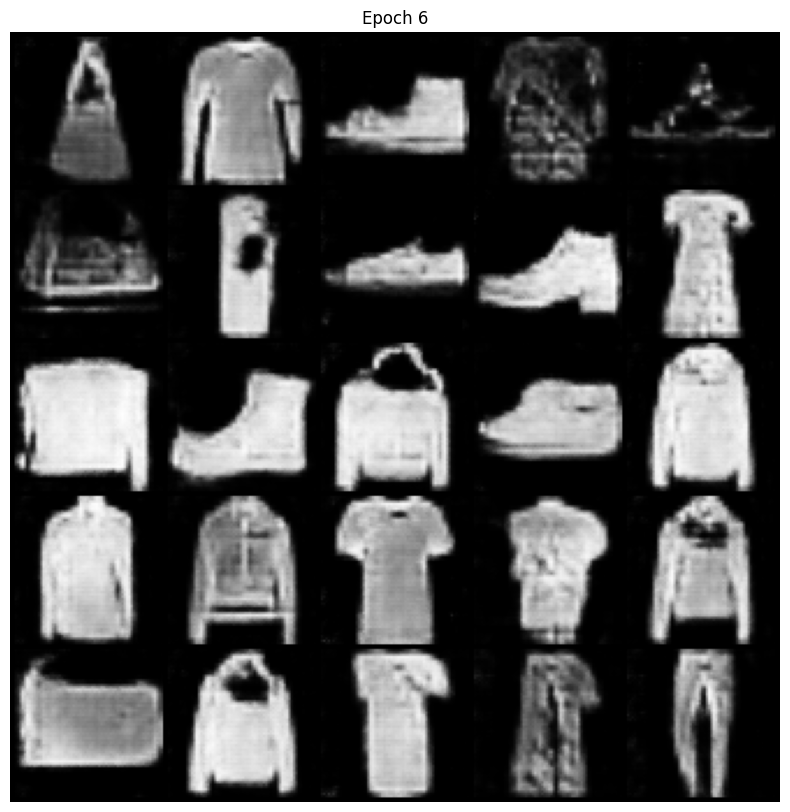

[Epoch 7/10] [Batch 0/938] [D loss: 0.0258] [G loss: 4.0069]
[Epoch 7/10] [Batch 100/938] [D loss: 0.0101] [G loss: 4.9014]
[Epoch 7/10] [Batch 200/938] [D loss: 0.0950] [G loss: 2.5722]
[Epoch 7/10] [Batch 300/938] [D loss: 0.1636] [G loss: 2.1493]
[Epoch 7/10] [Batch 400/938] [D loss: 0.0118] [G loss: 4.6124]
[Epoch 7/10] [Batch 500/938] [D loss: 0.0744] [G loss: 3.6911]
[Epoch 7/10] [Batch 600/938] [D loss: 0.0310] [G loss: 5.4781]
[Epoch 7/10] [Batch 700/938] [D loss: 0.0107] [G loss: 4.8831]
[Epoch 7/10] [Batch 800/938] [D loss: 0.0927] [G loss: 2.4909]
[Epoch 7/10] [Batch 900/938] [D loss: 0.0332] [G loss: 5.1398]


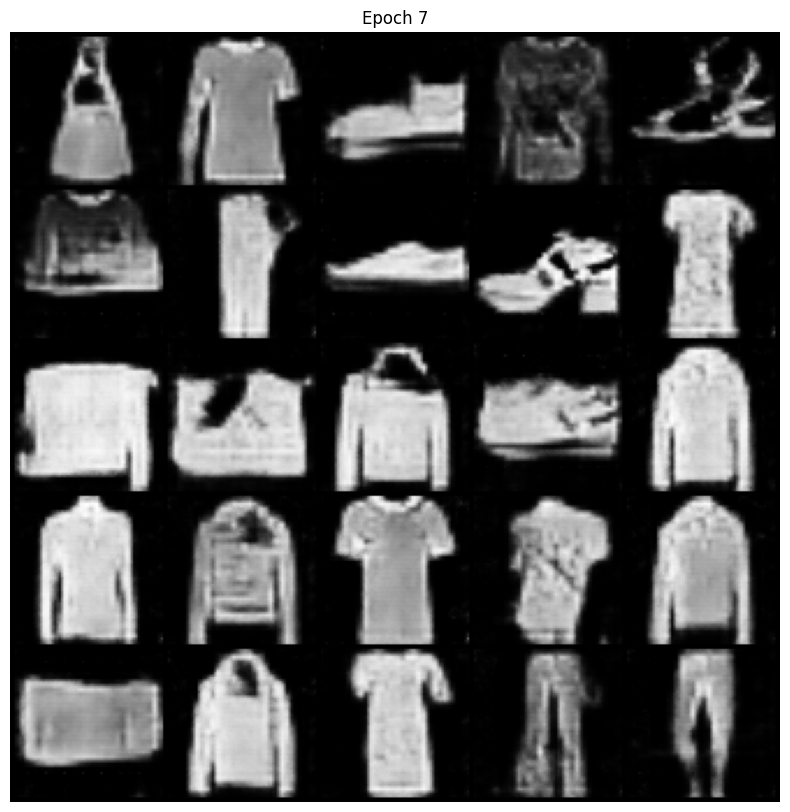

[Epoch 8/10] [Batch 0/938] [D loss: 0.0048] [G loss: 5.9448]
[Epoch 8/10] [Batch 100/938] [D loss: 0.1574] [G loss: 3.2106]
[Epoch 8/10] [Batch 200/938] [D loss: 0.0372] [G loss: 3.6975]
[Epoch 8/10] [Batch 300/938] [D loss: 0.0169] [G loss: 4.4956]
[Epoch 8/10] [Batch 400/938] [D loss: 0.0282] [G loss: 5.5642]
[Epoch 8/10] [Batch 500/938] [D loss: 0.1476] [G loss: 4.0205]
[Epoch 8/10] [Batch 600/938] [D loss: 0.2829] [G loss: 1.7141]
[Epoch 8/10] [Batch 700/938] [D loss: 0.0279] [G loss: 3.6081]
[Epoch 8/10] [Batch 800/938] [D loss: 0.0866] [G loss: 3.4409]
[Epoch 8/10] [Batch 900/938] [D loss: 0.0997] [G loss: 7.5855]


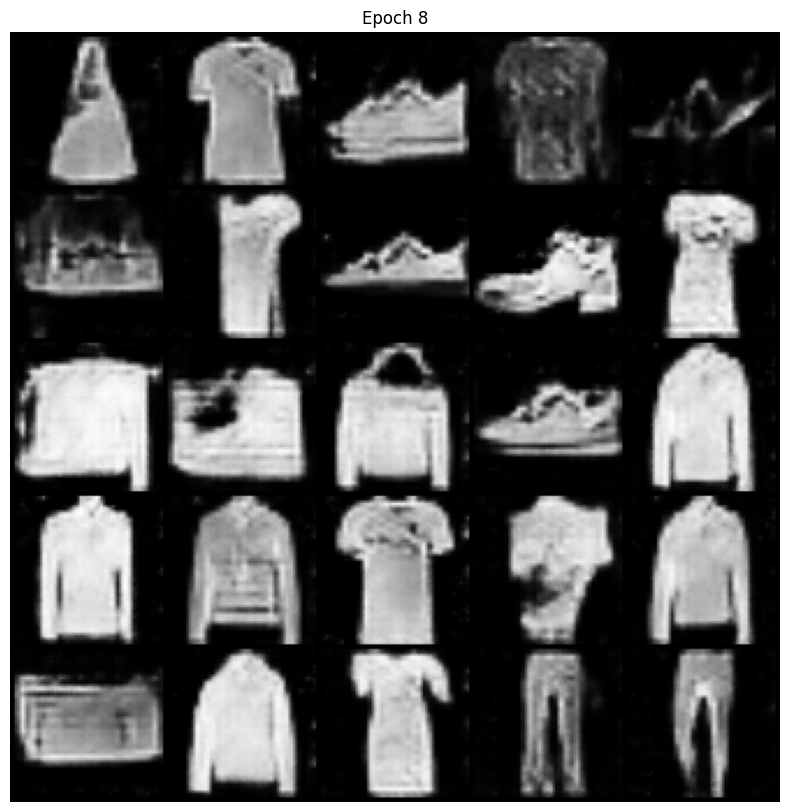

[Epoch 9/10] [Batch 0/938] [D loss: 0.0111] [G loss: 5.0090]
[Epoch 9/10] [Batch 100/938] [D loss: 0.1122] [G loss: 4.4253]
[Epoch 9/10] [Batch 200/938] [D loss: 0.0119] [G loss: 4.9933]
[Epoch 9/10] [Batch 300/938] [D loss: 0.0030] [G loss: 6.0065]
[Epoch 9/10] [Batch 400/938] [D loss: 0.0349] [G loss: 3.6081]
[Epoch 9/10] [Batch 500/938] [D loss: 0.1371] [G loss: 3.5429]
[Epoch 9/10] [Batch 600/938] [D loss: 0.0421] [G loss: 6.8669]
[Epoch 9/10] [Batch 700/938] [D loss: 0.0334] [G loss: 4.7257]
[Epoch 9/10] [Batch 800/938] [D loss: 0.0321] [G loss: 6.5686]
[Epoch 9/10] [Batch 900/938] [D loss: 0.0042] [G loss: 6.3305]


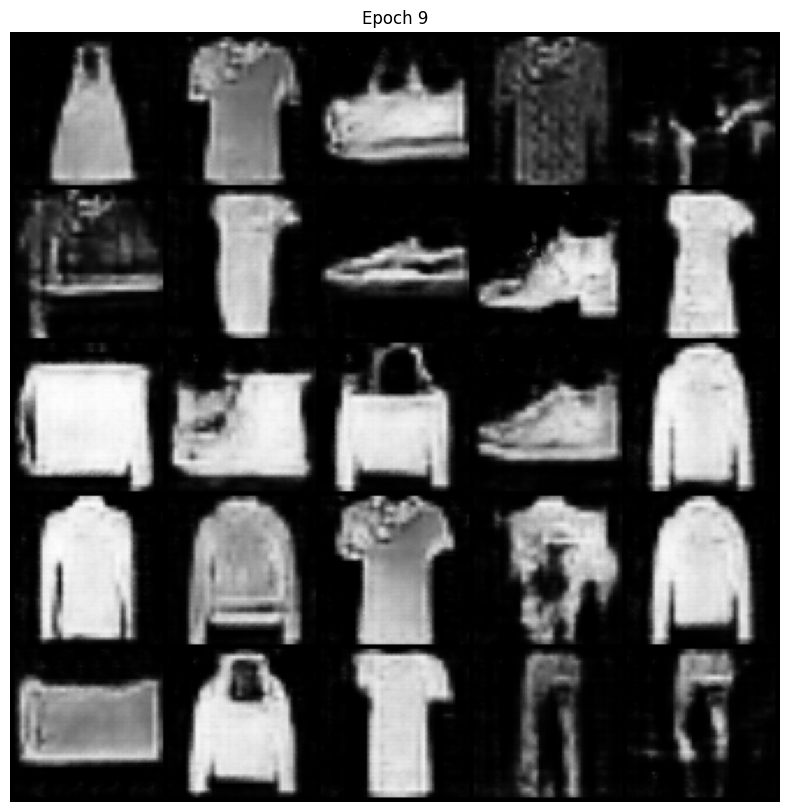

[Epoch 10/10] [Batch 0/938] [D loss: 0.1201] [G loss: 2.8691]
[Epoch 10/10] [Batch 100/938] [D loss: 0.2373] [G loss: 1.9228]
[Epoch 10/10] [Batch 200/938] [D loss: 0.2901] [G loss: 1.7430]
[Epoch 10/10] [Batch 300/938] [D loss: 0.0168] [G loss: 4.3346]
[Epoch 10/10] [Batch 400/938] [D loss: 0.0110] [G loss: 4.9771]
[Epoch 10/10] [Batch 500/938] [D loss: 0.0115] [G loss: 6.4616]
[Epoch 10/10] [Batch 600/938] [D loss: 0.1117] [G loss: 4.1411]
[Epoch 10/10] [Batch 700/938] [D loss: 0.0411] [G loss: 3.6966]
[Epoch 10/10] [Batch 800/938] [D loss: 0.0461] [G loss: 3.6132]
[Epoch 10/10] [Batch 900/938] [D loss: 0.0333] [G loss: 4.4033]


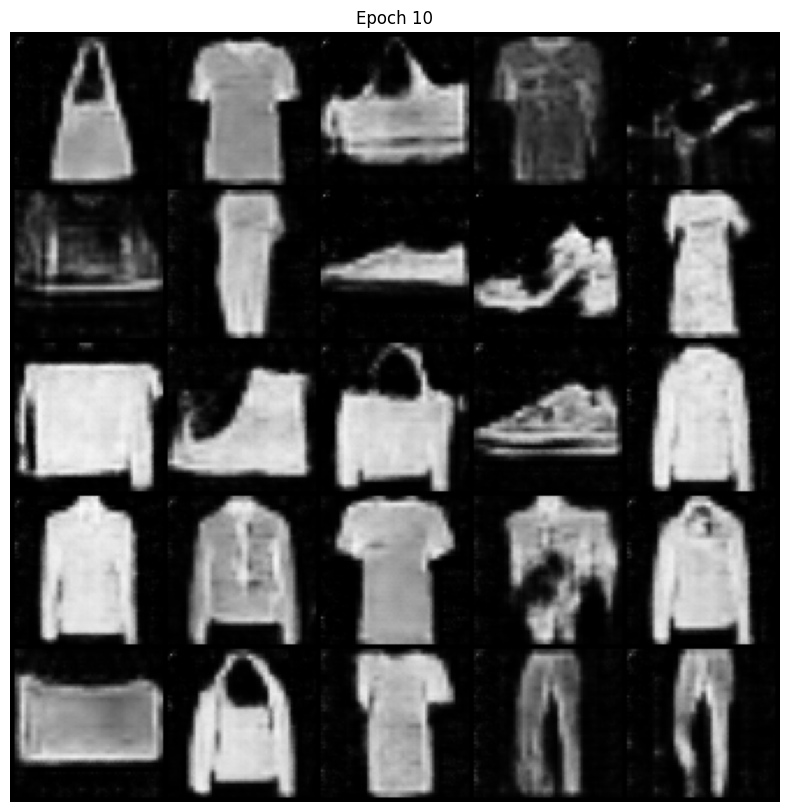

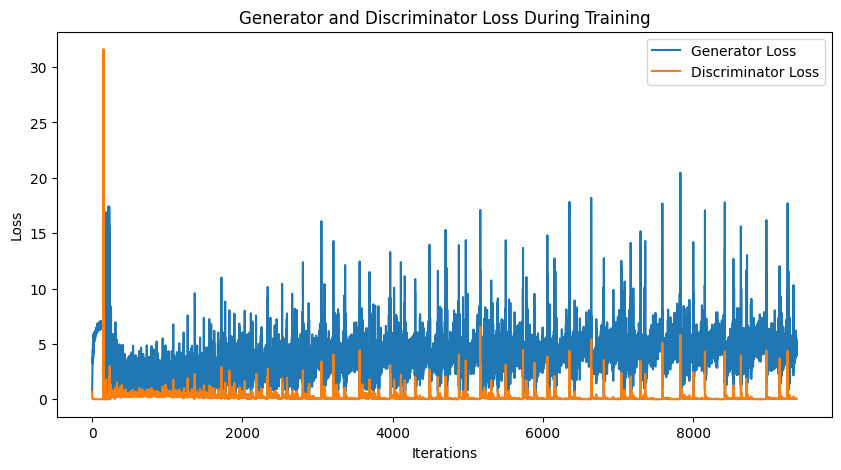

Real images path exists: True
Generated images path exists: True


100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


AssertionError: Training and test covariances have different dimensions

In [ ]:
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)


        gan.optimizer_G.zero_grad()

        z = torch.randn(real_imgs.size(0), latent_dim, 1, 1, device=device)
        gen_imgs = gan.generator(z)

        g_loss = gan.criterion(gan.discriminator(gen_imgs), valid)

        g_loss.backward()
        gan.optimizer_G.step()

        gan.optimizer_D.zero_grad()

        real_loss = gan.criterion(gan.discriminator(real_imgs), valid)
        fake_loss = gan.criterion(gan.discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        gan.optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    if epoch == 0:
        real_images_sample = next(iter(dataloader))[0]
        vutils.save_image(real_images_sample, os.path.join(real_path, 'real_sample.png'), nrow=5, normalize=True)

    with torch.no_grad():
        gen_imgs = gan.generator(fixed_noise).cpu()
    vutils.save_image(gen_imgs, os.path.join(generated_path, f'generated_sample_epoch_{epoch+1}.png'), nrow=5, normalize=True)

    grid = torchvision.utils.make_grid(gen_imgs, nrow=5, normalize=True)
    np_grid = grid.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(f'Epoch {epoch+1}')
    plt.axis('off')
    plt.show()

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator Loss")
plt.plot(D_losses, label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

print("Real images path exists:", os.path.exists(real_path))
print("Generated images path exists:", os.path.exists(generated_path))

fid_value = fid_score.calculate_fid_given_paths([real_path, generated_path], batch_size, device, dims=2048)
print(f"FID Score: {fid_value}")


In [ ]:
real_path = './real_images'
generated_path_epoch = './generated_images'

os.makedirs(real_path, exist_ok=True)
os.makedirs(generated_path_epoch, exist_ok=True)

gan = GAN(latent_dim=latent_dim, lr=lr)
fixed_noise = torch.randn(25, latent_dim, 1, 1, device=device)

G_losses = []
D_losses = []
FID_scores = []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)

        valid = torch.ones(real_imgs.size(0), 1, device=device)
        fake = torch.zeros(real_imgs.size(0), 1, device=device)

        gan.optimizer_G.zero_grad()
        z = torch.randn(real_imgs.size(0), latent_dim, 1, 1, device=device)
        gen_imgs = gan.generator(z)
        g_loss = gan.criterion(gan.discriminator(gen_imgs), valid)
        g_loss.backward()
        gan.optimizer_G.step()

        gan.optimizer_D.zero_grad()
        real_loss = gan.criterion(gan.discriminator(real_imgs), valid)
        fake_loss = gan.criterion(gan.discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        gan.optimizer_D.step()

        G_losses.append(g_loss.item())
        D_losses.append(d_loss.item())

        if i % 100 == 0:
            print(f"[Epoch {epoch+1}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

    if epoch == 0:
        real_images_sample = next(iter(dataloader))[0]
        vutils.save_image(real_images_sample, os.path.join(real_path, 'real_sample.png'), nrow=5, normalize=True)

    generated_epoch_dir = os.path.join(generated_path_epoch, f'epoch_{epoch+1}')
    os.makedirs(generated_epoch_dir, exist_ok=True)
    with torch.no_grad():
        for j in range(0, len(dataloader.dataset), batch_size):
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
            gen_imgs = gan.generator(noise).cpu()
            for k, img in enumerate(gen_imgs):
                torchvision.utils.save_image(img, os.path.join(generated_epoch_dir, f'img_{j+k}.png'), normalize=True)

    fid_value = fid_score.calculate_fid_given_paths([real_path, generated_epoch_dir], batch_size, device, dims=2048)
    FID_scores.append(fid_value)
    print(f"FID Score at Epoch {epoch+1}: {fid_value}")

    with torch.no_grad():
        gen_imgs = gan.generator(fixed_noise).cpu()
    grid = torchvision.utils.make_grid(gen_imgs, nrow=5, normalize=True)
    np_grid = grid.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(np_grid, (1, 2, 0)))
    plt.title(f'Epoch {epoch+1} (FID: {fid_value:.2f})')
    plt.axis('off')
    plt.show()

plt.figure(figsize=(10, 5))
plt.title("FID Score During Training")
plt.plot(range(1, epochs+1), FID_scores, marker='o', label="FID Score")
plt.xlabel("Epoch")
plt.ylabel("FID Score")
plt.legend()
plt.grid()
plt.show()

torch.save(gan.generator.state_dict(), 'generator.pth')
torch.save(gan.discriminator.state_dict(), 'discriminator.pth')


100 generated samples saved to ./generated_samples/generated_samples.png




### **1. Initial Setup**
- **Directory Creation:** Separate folders are created to save:
  - Real images sampled from the dataset (used to compute FID).
  - Generated images created by the GAN during each training epoch for evaluation.
- **GAN Initialization:** The GAN consists of:
  - A **generator**, which creates fake images from random noise.
  - A **discriminator**, which classifies images as real or fake.
  - Learning rates and optimizers for both networks are configured.
- **Fixed Noise:** A predefined batch of random noise is generated. This fixed input ensures consistent outputs from the generator for visualizing progress over epochs.

---

### **2. Training Loop**
For a specified number of epochs, the GAN is trained using the following steps:

#### **a. Discriminator Training**
1. **Real Images:** The discriminator is fed real images from the dataset, labeled as `real`.
2. **Fake Images:** The generator creates fake images using random noise. These images are fed to the discriminator, labeled as `fake`.
3. **Loss Calculation:** The discriminator’s loss is calculated as the average error in predicting the labels for both real and fake images.
4. **Update:** The discriminator’s weights are updated through backpropagation to improve its classification performance.

#### **b. Generator Training**
1. **Generate Fake Images:** The generator creates fake images using random noise.
2. **Loss Calculation:** The discriminator evaluates these fake images, and the generator’s loss is computed based on how well the fake images are classified as real by the discriminator.
3. **Update:** The generator’s weights are updated to improve its ability to fool the discriminator.

#### **c. Logging**
- **Losses:** Generator and discriminator losses are recorded for analysis.
- **Periodic Updates:** Training progress is printed periodically for monitoring.

---

### **3. End-of-Epoch Tasks**
At the end of each epoch, the following tasks are performed:

#### **a. Real Image Sampling**
- A sample of real images from the dataset is saved for visual comparison with generated images.

#### **b. Generate Images for the Current Epoch**
- The generator creates a batch of fake images using random noise.
- These images are saved in a folder specific to the current epoch for evaluation.

#### **c. FID Score Calculation**
- The Frechet Inception Distance (FID) is computed between the real images and the generated images. This score evaluates the similarity between the two distributions:
  - Lower FID scores indicate that the generated images closely resemble the real images.
  - FID scores are recorded for each epoch.

#### **d. Visualize Generated Images**
- Using the fixed noise vector, a grid of generated images is created and displayed. This provides a visual measure of the generator’s progress over time.

---

### **4. Final Metrics Visualization**
- **FID Score Plot:** A line graph shows the change in FID scores across epochs, helping to monitor improvements in the quality of generated images.
- **Generated Images:** A final set of images generated from the fixed noise is displayed for visual assessment.

---

### **5. Model Saving**
- The trained generator and discriminator models are saved for future use. This allows you to:
  - Generate new images with the trained generator.
  - Resume training or evaluation with the discriminator.

---

### **Purpose of This Workflow**
1. **Training Stability:** The alternating training of the generator and discriminator ensures balanced progress for both networks.
2. **Progress Evaluation:** The combination of FID scores and visual inspections provides quantitative and qualitative insights into the training process.
3. **Reproducibility:** Saving models, generated images, and metrics ensures that the results can be reproduced and analyzed further.

This structured approach enables systematic training and evaluation of the GAN while ensuring a clear record of progress.

### **Frechet Inception Distance (FID) in the Code**

FID (Frechet Inception Distance) is a widely used metric to evaluate the quality of images generated by GANs. It measures how closely the distribution of generated images matches the distribution of real images. Lower FID scores indicate that the generated images are more similar to the real images in terms of features.

Here’s how FID is implemented and used in your code:

---

### **1. Purpose of FID in the Code**
In the code, FID serves as a quantitative metric to:
- Evaluate the quality of the images generated by the GAN.
- Track progress over epochs to monitor improvement in generation quality.

---

### **2. How FID Works**

#### **a. Computing Feature Representations**
FID compares the high-level features of real and generated images. These features are extracted using a pre-trained **Inception v3** network. Instead of directly comparing pixel values, FID analyzes distributions in a feature space learned by Inception v3.

#### **b. Modeling Distributions**
For both real and generated images:
- Feature vectors are extracted from the Inception network.
- The distributions of these feature vectors are modeled as **multivariate Gaussians**, characterized by:
  - **Mean (\(\mu\)):** Average feature vector.
  - **Covariance (\(\Sigma\)):** Covariance of the feature vectors.

#### **c. Computing the Frechet Distance**
The FID between the two distributions (\(\mu_r, \Sigma_r\)) for real images and (\(\mu_g, \Sigma_g\)) for generated images is calculated as:
\[
FID = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})
\]
Where:
- \( \|\mu_r - \mu_g\|^2 \): Squared difference between the means of the two distributions.
- \( \text{Tr} \): Trace operator, summing the diagonal elements of a matrix.
- \( (\Sigma_r \Sigma_g)^{1/2} \): Matrix square root of the product of the covariance matrices.

This equation captures both the difference in the central tendency (mean) and the spread (covariance) of the feature distributions.

---

### **3. FID in the Code**

#### **Calculation**
```python
fid_value = fid_score.calculate_fid_given_paths([real_path, generated_epoch_dir], batch_size, device, dims=2048)
FID_scores.append(fid_value)
```
- **`real_path` and `generated_epoch_dir`:**
  - `real_path`: Directory containing real images sampled from the dataset.
  - `generated_epoch_dir`: Directory containing images generated by the GAN for the current epoch.
- **`calculate_fid_given_paths`:**
  - This function compares the images in these directories and computes the FID score.
  - `batch_size`: Specifies how many images to process at a time.
  - `dims=2048`: Indicates the dimensionality of the feature space extracted from Inception v3.

#### **Evaluation**
The FID score is computed after every epoch and appended to `FID_scores`. This provides a record of how the quality of the generated images evolves during training.

---

### **4. Visualization of FID Progress**
```python
plt.plot(range(1, epochs+1), FID_scores, marker='o', label="FID Score")
```
- A plot is generated at the end of training to show the trend of FID scores across epochs.
- This helps you observe:
  - If FID scores are decreasing, it indicates the generated images are becoming more similar to the real images.
  - If FID scores stagnate or increase, it may signal issues in training.

---

### **5. Why FID is Important**
- **High-Level Comparison:** FID focuses on features extracted from a deep neural network rather than pixel-level similarities, making it robust to minor pixel variations.
- **Evaluates Diversity and Quality:** FID considers both:
  - **Image quality:** Generated images should resemble real images.
  - **Diversity:** Generated images should cover the variability seen in the real dataset.
- **Common Metric:** FID is a standard benchmark in GAN research, allowing comparison with other models.

---

### **6. Key Observations in the Code**
- **Consistent Evaluation:** FID is computed for each epoch, using all generated images for that epoch compared to a fixed set of real images.
- **Quantitative Feedback:** By tracking FID scores, you can objectively measure whether the generator is improving.

---

### **Summary**
In this code, FID is used as a crucial metric to evaluate and track the quality of GAN-generated images. By comparing the feature distributions of real and generated images using a pre-trained Inception v3 network, FID provides a robust measure of similarity that combines quality and diversity. Lower FID scores across epochs indicate that the generator is producing images more similar to the real dataset, both visually and statistically.